# Full circuit for 1+1d SU(2) Trotter simulation using the LSH formulation with $L=4$, $\Lambda=2$

Using a qutrit to represent the bosonic dof at r=2.

The possible quantum numbers at each site are:
- r=0:
  - (ni, no) = (0, 0), (0, 1), (1, 1)
  - nl = 0
- r=1:
  - (ni, no) = all combinations
  - nl = 0, 1
- r=2: all combinations
- r=3: (ni, no, nl) = (0, 0, 1), (0, 1, 0), (1, 0, 1), (1, 1, 1)

Considering first-order Trotter for the moment.

In [1]:
import os
import sys
sys.path.append('/home/iiyama/src/qutrit-experiments')
sys.path.append('/home/iiyama/src/lsh-qudit')
from copy import deepcopy
from collections import defaultdict
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, transpile, qpy
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit_ibm_runtime.fake_provider import FakeKawasaki
from qutrit_experiments.gates import X12Gate, P1Gate, P2Gate, RZ12Gate, QGate, XplusGate, XminusGate
from lsh_qudit.diag_terms import diag_propagator_circuit, get_opt3_pm
from lsh_qudit.validator import validate_circuit
from lsh_qudit.utils import remove_idle_wires, op_matrix

In [2]:
op_matrix(np.array([[0., 1.], [1., 0.]]), (2, 2, 2), 2)

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [3]:
circuit_repo_path = '/data/iiyama/lsh-qudit/circuits'

## Model parameters

In [4]:
num_sites = 4
mass_mu = 1.
interaction_x = 1.

time_step = Parameter('$\Delta$t')

backend = FakeKawasaki()
qubit_mapping = ({f'i{i}': q for i, q in enumerate([6, 7, 26, 27])}
                 | {f'o{i}': q for i, q in enumerate([5, 8, 16, 28])}
                 | {f'l{i}': q for i, q in enumerate([126, 9, 24, 125])}
                 | {'a0': 25})

In [5]:
fermion_i = QuantumRegister(num_sites, name='fermion_i')
fermion_o = QuantumRegister(num_sites, name='fermion_o')
boson = QuantumRegister(num_sites, name='boson')
ancilla = QuantumRegister(num_sites - 3, name='ancilla')

bulk_fermion_i = fermion_i[2:num_sites - 1]
bulk_fermion_o = fermion_o[2:num_sites - 1]
bulk_boson = boson[2:num_sites - 1]

In [6]:
p0 = SparsePauliOp(['I', 'Z'], [0.5, 0.5])
p1 = SparsePauliOp(['I', 'Z'], [0.5, -0.5])

## $H_M$

$$
\begin{align*}
H_{M}(r) &= H_{M}^{(1)}(r) + H_{M}^{(2)}(r)\,, \\
H_{M}^{(1)}(r) &= \frac{\mu}{2}(-)^{r+1}Z_{2r}\,,\\
H_{M}^{(2)}(r) &= \frac{\mu}{2}(-)^{r+1}Z_{2r+1}\,
\end{align*}
$$

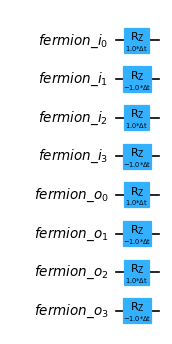

In [7]:
mass_circuit = QuantumCircuit(fermion_i, fermion_o, boson, ancilla)
for isite in range(num_sites):
    mass_circuit.rz(((-1) ** isite) * mass_mu * time_step, fermion_i[isite])
    mass_circuit.rz(((-1) ** isite) * mass_mu * time_step, fermion_o[isite])
remove_idle_wires(mass_circuit)
mass_circuit.draw('mpl', scale=0.6)

In [8]:
dt = 0.73
paulis = ['I' * (8 - iq - 1) + 'Z' + 'I' * iq for iq in range(8)]
coeffs = (1. - 2. * (np.arange(8) % 2)) * mass_mu / 2. * dt
hmat = SparsePauliOp(paulis, coeffs).to_matrix()
validate_circuit(mass_circuit.assign_parameters({time_step: dt}, inplace=False), hmat)

(True,
 array([[1.       -9.00506805e-17j, 0.       +0.00000000e+00j,
         0.       +0.00000000e+00j, ..., 0.       +0.00000000e+00j,
         0.       +0.00000000e+00j, 0.       +0.00000000e+00j],
        [0.       +0.00000000e+00j, 0.7451744+6.66869635e-01j,
         0.       +0.00000000e+00j, ..., 0.       +0.00000000e+00j,
         0.       +0.00000000e+00j, 0.       +0.00000000e+00j],
        [0.       +0.00000000e+00j, 0.       +0.00000000e+00j,
         0.7451744-6.66869635e-01j, ..., 0.       +0.00000000e+00j,
         0.       +0.00000000e+00j, 0.       +0.00000000e+00j],
        ...,
        [0.       +0.00000000e+00j, 0.       +0.00000000e+00j,
         0.       +0.00000000e+00j, ..., 0.7451744+6.66869635e-01j,
         0.       +0.00000000e+00j, 0.       +0.00000000e+00j],
        [0.       +0.00000000e+00j, 0.       +0.00000000e+00j,
         0.       +0.00000000e+00j, ..., 0.       +0.00000000e+00j,
         0.7451744-6.66869635e-01j, 0.       +0.00000000e+00j],
     

## $H_E$

$$
\begin{align}
H_{E}&=H_{E}^{(1)} + H_{E}^{(2)} + H_{E}^{(3)}
\\
H_{E}^{(1)} & = \frac{1}{2}n_{l}(r)\,,
\\
H_{E}^{(2)} & = \frac{1}{4}n_{l}(r)^{2}\,,
\\
H_{E}^{(3)} & = \frac{1}{2}\left[n_{l}(r)+\frac{3}{2}\right] n_{o}(r) \left(1-n_{i}(r)\right)\,.
\end{align}
$$

### $H_E^{(1)} + H_E^{(2)}$

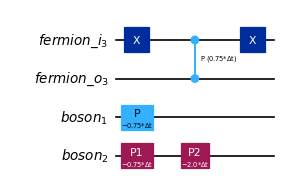

In [13]:
ele12_circuit = QuantumCircuit(fermion_i, fermion_o, boson, ancilla)
# r=1: nl=0 or 1
ele12_circuit.p(-0.75 * time_step, boson[1])
# Bulk
for qubit in bulk_boson:
    ele12_circuit.append(P1Gate(-0.75 * time_step), [qubit])
    ele12_circuit.append(P2Gate(-2. * time_step), [qubit])
# r=L-1: nl=0 if (ni, no)=(0, 1) and nl=1 otherwise -> retard the phase by -0.75 for (ni, no)=(0, 1)
ele12_circuit.x(fermion_i[num_sites - 1])
ele12_circuit.cp(0.75 * time_step, fermion_i[num_sites - 1], fermion_o[num_sites - 1])
ele12_circuit.x(fermion_i[num_sites - 1])
remove_idle_wires(ele12_circuit, inplace=False).draw('mpl', scale=0.6)

In [14]:
qubit_map = {fermion_i[3]: 0, fermion_o[3]: 1, boson[1]: 2, boson[2]: 3}
test_circ = QuantumCircuit(4)
for datum in ele12_circuit.assign_parameters({time_step: dt}, inplace=False).data:
    qubits = [qubit_map[q] for q in datum.qubits]
    test_circ.append(datum.operation, qubits)

shape = (3, 2, 2, 2)
nl = np.arange(2)
hmat = op_matrix(np.diagflat(0.5 * nl + 0.25 * np.square(nl)), shape, 2)
nl = np.arange(3)
hmat += op_matrix(np.diagflat(0.5 * nl + 0.25 * np.square(nl)), shape, 3)
nl = np.array([1, 1, 0, 1])
hmat += op_matrix(np.diagflat(0.5 * nl + 0.25 * np.square(nl)), shape, (1, 0))
hmat *= dt

isid, unitary, target = validate_circuit(test_circ, hmat, qutrits=(3,))

### $H_E^{(3)}$

In [ ]:
ele3_circuit = QuantumCircuit(fermion_i, fermion_o, boson, ancilla)

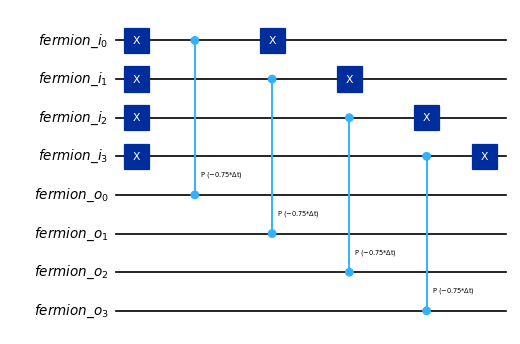

In [24]:
# 3/4 * (1 - n_i) * n_o
ele3f_circuit = ele3_circuit.copy_empty_like()
ele3f_circuit.x(fermion_i)
ele3f_circuit.cp(-0.75 * time_step, fermion_i, fermion_o)
ele3f_circuit.x(fermion_i)
ele3_circuit.compose(ele3f_circuit, inplace=True)
remove_idle_wires(ele3f_circuit, inplace=False).draw('mpl', scale=0.6)

In [25]:
qubit_map = ({q: i for i, q in enumerate(fermion_i)}
             | {q: 4 + i for i, q in enumerate(fermion_o)})
test_circ = QuantumCircuit(8)
for datum in ele3f_circuit.assign_parameters({time_step: dt}, inplace=False).data:
    qubits = [qubit_map[q] for q in datum.qubits]
    test_circ.append(datum.operation, qubits)

shape = (2,) * 8
diag = np.array([0., 0., 0.75, 0.])
hmat = op_matrix(np.diagflat(diag), shape, (4, 0))
hmat += op_matrix(np.diagflat(diag), shape, (5, 1))
hmat += op_matrix(np.diagflat(diag), shape, (6, 2))
hmat += op_matrix(np.diagflat(diag), shape, (7, 3))
hmat *= dt

validate_circuit(test_circ, hmat, diagonal=True)

(True,
 array([ 1.        +0.j        ,  1.        +0.j        ,
         1.        +0.j        ,  1.        +0.j        ,
         1.        +0.j        ,  1.        +0.j        ,
         1.        +0.j        ,  1.        +0.j        ,
         1.        +0.j        ,  1.        +0.j        ,
         1.        +0.j        ,  1.        +0.j        ,
         1.        +0.j        ,  1.        +0.j        ,
         1.        +0.j        ,  1.        +0.j        ,
         0.85382857-0.52055429j,  1.        +0.j        ,
         0.85382857-0.52055429j,  1.        +0.j        ,
         0.85382857-0.52055429j,  1.        +0.j        ,
         0.85382857-0.52055429j,  1.        +0.j        ,
         0.85382857-0.52055429j,  1.        +0.j        ,
         0.85382857-0.52055429j,  1.        +0.j        ,
         0.85382857-0.52055429j,  1.        +0.j        ,
         0.85382857-0.52055429j,  1.        +0.j        ,
         0.85382857-0.52055429j,  0.85382857-0.52055429j,
       

In [26]:
# 1/2 * n_l * (1 - n_i) * n_o
#  r=1
path = os.path.join(circuit_repo_path, 'ele3_r1.qpy')
if os.path.exists(path):
    with open(path, 'rb') as source:
        circ = qpy.load(source)[0]
else:
    # n_i projection is originally p0, but we have x(fermion_i) above so use p1 here
    op = p1.tensor(p1).tensor(p1) * 0.5 * time_step
    circ = diag_propagator_circuit(op, backend, [qubit_mapping[x] for x in ['i1', 'o1', 'l1']])
    with open(path, 'wb') as out:
        qpy.dump(circ, out)
ele3r1_circuit = ele3_circuit.copy_empty_like()
ele3r1_circuit.x(fermion_i)
ele3r1_circuit.compose(circ, qubits=[fermion_i[1], fermion_o[1], boson[1]], inplace=True)
ele3r1_circuit.x(fermion_i)
ele3_circuit.compose(ele3r1_circuit, inplace=True)
# Inefficient implementation:
# ele3r1_circuit.ccx(fermion_i[1], fermion_o[1], boson[1])
# ele3r1_circuit.rz(-0.25 * time_step, boson[1])
# ele3r1_circuit.ccx(fermion_i[1], fermion_o[1], boson[1])
# ele3r1_circuit.rz(0.25 * time_step, boson[1])
# ele3r1_circuit.cp(0.25 * time_step, fermion_i[1], fermion_o[1])
remove_idle_wires(ele3r1_circuit, inplace=False).draw('mpl', scale=0.6)

AttributeError: 'ParameterExpression' object has no attribute 'real'

In [ ]:

#  Bulk boson
#   Strategy: CCX on an ancilla, then CQ from ancilla to qutrit. CQ can be implemented with
#     CX02 - Q(-φ/2) - CX02 - Q(φ/2)
#   and CX02 is
#     X12 - CX01 - X12
ele3bulk_circuit = ele3_circuit.copy_empty_like()
ele3bulk_circuit.x(fermion_i)
ele3bulk_circuit.ccx(bulk_fermion_i, bulk_fermion_o, ancilla)
for qubit, anc in zip(bulk_boson, ancilla):
    ele3bulk_circuit.append(X12Gate(), [qubit])
    ele3bulk_circuit.cx(anc, qubit)
    ele3bulk_circuit.append(X12Gate(), [qubit])
    ele3bulk_circuit.append(QGate(-0.25 * time_step), [qubit])
    ele3bulk_circuit.append(X12Gate(), [qubit])
    ele3bulk_circuit.cx(anc, qubit)
    ele3bulk_circuit.append(X12Gate(), [qubit])
    ele3bulk_circuit.append(QGate(0.25 * time_step), [qubit])
ele3bulk_circuit.ccx(bulk_fermion_i, bulk_fermion_o, ancilla)
ele3bulk_circuit.x(fermion_i)
ele3_circuit.compose(ele3bulk_circuit, inplace=True)

remove_idle_wires(ele3_circuit, inplace=False).draw('mpl', scale=0.6)

In [ ]:
qubit_map = ({q: i for i, q in enumerate(fermion_i)}
             | {q: 4 + i for i, q in enumerate(fermion_o)}
             | {q: 8 + i for i, q in enumerate(boson[1:3])}
             | {ancilla[0]: 10})
test_circ = QuantumCircuit(11)
for datum in ele3_circuit.assign_parameters({time_step: dt}, inplace=False).data:
    qubits = [qubit_map[q] for q in datum.qubits]
    test_circ.append(datum.operation, qubits)

shape = (3, 2, 2, 2)
nl = np.arange(2)
hmat = op_matrix(np.diagflat(0.5 * nl + 0.25 * np.square(nl)), shape, 2)
nl = np.arange(3)
hmat += op_matrix(np.diagflat(0.5 * nl + 0.25 * np.square(nl)), shape, 3)
nl = np.array([1, 1, 0, 1])
hmat += op_matrix(np.diagflat(0.5 * nl + 0.25 * np.square(nl)), shape, (1, 0))
hmat *= dt

isid, unitary, target = validate_circuit(test_circ, hmat, qutrits=(3,))

## $H_I$

### $H_I^{(1)}$

The general form of $H_I^{(1)}$ is

$$
\begin{split}
\frac{1}{x} H_I^{(1)}(r) = & \ket{0}\bra{1}_{i(r)} Z_{o(r)} \ket{1}\bra{0}_{i(r+1)} \left[ \lambda^+_{l(r)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \right]^{1 - n_o(r)} \left[ \lambda^+_{l(r+1)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \right]^{n_o(r+1)} \mathcal{D}\left(n_l(r), n_o(r), n_o(r+1)\right) \\
& + \ket{1}\bra{0}_{i(r)} Z_{o(r)} \ket{0}\bra{1}_{i(r+1)} \mathcal{D}\left(n_l(r), n_o(r), n_o(r+1)\right)
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \lambda^-_{l(r)} \right]^{1 - n_o(r)}
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \lambda^-_{l(r+1)} \right]^{n_o(r+1)}
\end{split}
$$

Note that the combinations of the allowed $n_i$ and $n_o$ values together with AGL dictates that a
non-annihilated state will have $n_l(r) = n_l(r+1)$.


#### $H_I^{(1)}(r=0)$

For $r=0$, we set $n_l(0) = 0$ and $(n_i(0), n_o(0)) = (0, 0), (0, 1), (1, 1)$. From the AGL, quantum
numbers of $r=1$ is restricted to
|$(n_i(0), n_o(0))$|$(n_i(1), n_o(1), n_l(1))$|
|------------------|------------------|
|(0, 0) or (1, 1)|(0, 0, 0) (0, 1, 0) (1, 1, 0)|
|(0, 1)|(0, 0, 1) (0, 1, 1) (1, 0, 0) (1, 1, 1)|

The first term of $H_I^{(1)}(0)$ annihilates all quantum number combinations except for
- (1, 1, 0) (0, 0, 0)
- (1, 1, 0) (0, 1, 0)

For these combinations, the diagonal function is
$$
\mathcal{D}\left(n_l(0), n_o(0), n_o(1)\right) = \sqrt{\frac{0 + 1 + 1}{0 + 1 + n_o(1)}} = \sqrt{2} \ket{0}\bra{0}_{o(1)} + \ket{1}\bra{1}_{o(1)} = \frac{\sqrt{2} + 1}{2} + \frac{\sqrt{2} - 1}{2} Z_{o(1)},
$$
so the first term of the Hamiltonian simplifies to
$$
-\ket{0}\bra{1}_{i(0)} \ket{1}\bra{0}_{i(1)} \left[ \ket{0}\bra{0}_{o(1)} + \ket{1}\bra{1}_{o(1)} \ket{1}\bra{0}_{l(1)} \right] \left[\frac{\sqrt{2} + 1}{2} + \frac{\sqrt{2} - 1}{2} Z_{o(1)}\right].
$$

The second term annihilates everything except for
- (0, 0, 0) (1, 1, 0)
- (0, 1, 0) (1, 0, 0)
- (0, 1, 0) (1, 1, 1)

This term simplifies to
$$
-\ket{1}\bra{0}_{i(0)} \ket{0}\bra{1}_{i(1)} \left[\frac{\sqrt{2} + 1}{2} + \frac{\sqrt{2} - 1}{2} Z_{o(1)}\right]
\left[ \ket{0}\bra{0}_{o(1)} + \ket{1}\bra{1}_{o(1)} \ket{0}\bra{1}_{l(1)} \right]
$$
which is consistently the Hermitian conjugate of the simplified first term.

The diagonalizing unitary for this Hamiltonian is
$$
\mathcal{U}_{\mathrm{SVD}}^{(1)}(0) = H_{i(1)} \left[\ket{0}\bra{0}_{i(1)} + \ket{1}\bra{1}_{i(1)} X_{i(0)} (X_{l(1)})^{n_o(1)} \right].
$$
and the diagonalized Hamiltonian is
$$
\begin{split}
D^{(1)}(0) & = \mathcal{U}_{\mathrm{SVD}}^{(1)}(0) H_I^{(1)}(0) \mathcal{U}_{\mathrm{SVD}}^{(1)\dagger}(0) \\
& = -Z_{i(1)} \ket{1}\bra{1}_{i(0)} \left(\ket{0}\bra{0}_{l(1)}\right)^{n_o(1)} \left[\sqrt{2} \ket{0}\bra{0}_{o(1)} + \ket{1}\bra{1}_{o(1)}\right] \\
& = -Z_{i(1)} \ket{1}\bra{1}_{i(0)} \left[\sqrt{2} \ket{0}\bra{0}_{o(1)} I_{l(1)} + \ket{1}\bra{1}_{o(1)} \ket{0}\bra{0}_{l(1)}\right].
\end{split}
$$

In [ ]:
hi1r0_circuit = QuantumCircuit(fermion_i, fermion_o, boson)

# U_SVD(0)
hi1r0_circuit.ccx(fermion_i[1], fermion_o[1], boson[1])
hi1r0_circuit.cx(fermion_i[1], fermion_i[0])
hi1r0_circuit.h(fermion_i[1])

# exp[-itD(0)]
# D(0) = -1/4 (I - Z)_{i0} Z_{i1} ((√2+1)I + (√2-1)Z)_{o1}
# (√2+1)IZI -> (√2+1)ZZI -> (√2-1)ZZZ -> (√2-1)IZZ
phi = -0.25 * time_step
hi1r0_circuit.rz(phi * (np.sqrt(2.) + 1.), fermion_i[1])
hi1r0_circuit.cx(fermion_i[0], fermion_i[1])
hi1r0_circuit.rz(-phi * (np.sqrt(2.) + 1.), fermion_i[1])
hi1r0_circuit.cx(fermion_i[1], fermion_o[1])
hi1r0_circuit.rz(-phi * (np.sqrt(2.) - 1.), fermion_o[1])
hi1r0_circuit.cx(fermion_i[1], fermion_o[1])
hi1r0_circuit.cx(fermion_i[0], fermion_i[1])
hi1r0_circuit.cx(fermion_i[1], fermion_o[1])
hi1r0_circuit.rz(-phi * (np.sqrt(2.) - 1.), fermion_o[1])
hi1r0_circuit.cx(fermion_i[1], fermion_o[1])

# U_SVD(0)†
hi1r0_circuit.h(fermion_i[1])
hi1r0_circuit.cx(fermion_i[1], fermion_i[0])
hi1r0_circuit.ccx(fermion_i[1], fermion_o[1], boson[1])

#### $H_I^{(1)}(r=1)$

For $r=1$, the quantum number combinations are

|$(n_i(1), n_o(1), n_l(1))$|$(n_i(2), n_o(2), n_l(2))$|
|--------------------------|--------------------------|
|(0, 0, 0) (1, 0, 0) (1, 1, 0)|(0, 0, 0) (0, 1, 0) (1, 1, 0)|
|(0, 1, 0) (0, 0, 1) (1, 1, 1)|(0, 0, 1) (0, 1, 1) (1, 0, 0) (1, 1, 1)|
|(0, 1, 1)|(0, 0, 2) (0, 1, 2) (1, 0, 1) (1, 1, 2)|

The first term acts nontrivially on
- (1, 0, 0) (0, 0, 0)
- (1, 0, 0) (0, 1, 0)
- (1, 1, 0) (0, 0, 0)
- (1, 1, 0) (0, 1, 0)
- (1, 1, 1) (0, 0, 1)
- (1, 1, 1) (0, 1, 1)

The diagonal function is given by
$$
\begin{split}
\mathcal{D}\left(n_l(1), n_o(1), n_o(2)\right) = & \ket{0}\bra{0}_{l(1)} \left[ \ket{0}\bra{0}_{o(1)} + \sqrt{2}\ket{1}\bra{1}_{o(1)}\right] \left[ \ket{0}\bra{0}_{o(2)} + \frac{1}{\sqrt{2}}\ket{1}\bra{1}_{o(2)}\right] \\
& + \ket{1}\bra{1}_{l(1)} \left[ \sqrt{\frac{3}{2}} \ket{0}\bra{0}_{o(2)} + \ket{1}\bra{1}_{o(2)} \right] \\
= & \ket{0}\bra{0}_{l(1)} \left[ \frac{\sqrt{2} + 1}{2} - \frac{\sqrt{2} - 1}{2} Z_{o(1)} \right] \left[ \frac{\sqrt{2} + 1}{2\sqrt{2}} + \frac{\sqrt{2} - 1}{2\sqrt{2}} Z_{o(2)} \right] \\
& + \ket{1}\bra{1}_{l(1)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2 \sqrt{2}} + \frac{\sqrt{3} - \sqrt{2}}{2 \sqrt{2}} Z_{o(2)}\right] \\
\end{split}
$$

Since $n_l(1) = 0$ when $n_o(1) = 0$, $\left[\lambda^+_{l(1)} (1 - \ket{\Lambda}\bra{\Lambda})_{l(1)}\right]^{1 - n_o(1)} \to \left[\ket{1}\bra{0}_{l(1)}\right]^{1 - n_o(1)}$.
Similarly, $(1 - \ket{\Lambda}\bra{\Lambda})_{l(2)} \to 1$. The simplified first term is therefore
$$
\ket{0}\bra{1}_{i(1)} Z_{o(1)} \ket{1}\bra{0}_{i(2)} \left[\ket{1}\bra{0}_{l(1)}\right]^{1 - n_o(1)} \left[ \lambda^+_{l(2)}
 \right]^{n_o(2)} \mathcal{D}\left(n_l(1), n_o(1), n_o(2)\right).
$$

The second term acts on
- (0, 0, 0) (1, 1, 0)
- (0, 1, 0) (1, 0, 0)
- (0, 1, 0) (1, 1, 1)
- (0, 0, 1) (1, 0, 0)
- (0, 0, 1) (1, 1, 1)
- (0, 1, 1) (1, 0, 1)
- (0, 1, 1) (1, 1, 2)

Case $n_o(1) = 0, n_l(1) = 0$ will be annihilated by the projector. Then $n_l(2) = 1,2$ when $n_o(2) = 1$. The second term simplifies to
$$
\ket{1}\bra{0}_{i(1)} Z_{o(1)} \ket{0}\bra{1}_{i(2)} \mathcal{D}\left(n_l(1), n_o(1), n_o(2)\right)
\left[ \ket{0}\bra{1}_{l(1)} \right]^{1 - n_o(1)} 
\left[ \lambda^-_{l(2)} \right]^{n_o(2)}.
$$

The two terms are again consistently conjugates of each other.

The diagonalizing unitary is
$$
\mathcal{U}_{\mathrm{SVD}}^{(1)}(1) = H_{i(2)} \left[ \ket{0}\bra{0}_{i(2)}
 + \ket{1}\bra{1}_{i(2)} X_{i(1)} \left[X_{l(1)}\right]^{1 - n_o(1)} \left[\lambda^-_{l(2)}\right]^{n_o(2)} \right]
$$


and the diagonalized Hamiltonian is
$$
\begin{split}
D^{(1)}(1) = & Z_{i(2)} \ket{1}\bra{1}_{i(1)} \left[\ket{0}\bra{0}_{l(1)}\right]^{1-n_o(1)} \left\{ \ket{0}\bra{0}_{l(1)} \left[ \frac{\sqrt{2} + 1}{2} Z_{o(1)} - \frac{\sqrt{2} - 1}{2} \right] \left[ \frac{\sqrt{2} + 1}{2\sqrt{2}} + \frac{\sqrt{2} - 1}{2\sqrt{2}} Z_{o(2)} \right] 
 + \ket{1}\bra{1}_{l(1)} Z_{o(1)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2 \sqrt{2}} + \frac{\sqrt{3} - \sqrt{2}}{2 \sqrt{2}} Z_{o(2)}\right] \right\} \\
 = & Z_{i(2)} \ket{1}\bra{1}_{i(1)} \left\{ \ket{0}\bra{0}_{l(1)} \left[ \frac{\sqrt{2} + 1}{2} Z_{o(1)} - \frac{\sqrt{2} - 1}{2} \right] \left[ \frac{\sqrt{2} + 1}{2\sqrt{2}} + \frac{\sqrt{2} - 1}{2\sqrt{2}} Z_{o(2)} \right] 
 - \ket{1}\bra{1}_{l(1)} \ket{1}\bra{1}_{o(1)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2 \sqrt{2}} + \frac{\sqrt{3} - \sqrt{2}}{2 \sqrt{2}} Z_{o(2)}\right] \right\}
\end{split}
$$


The input states to the diagonal Hamiltonian have $(n_i(1), n_o(1), n_l(1), n_o(2), n_l(2))$ values
- (1, 0, 0, 0, 0)
- (1, 0, 0, 1, 0)
- (1, 1, 0, 0, 0)
- (1, 1, 0, 1, 0)
- (1, 1, 1, 0, 1)
- (1, 1, 1, 1, 1)

so some projectors can be replaced with identity:
$$
D^{(1)}(1) = Z_{i(2)} \left\{ \ket{0}\bra{0}_{l(1)} \left[ \frac{\sqrt{2} + 1}{2} Z_{o(1)} - \frac{\sqrt{2} - 1}{2} \right] \left[ \frac{\sqrt{2} + 1}{2\sqrt{2}} + \frac{\sqrt{2} - 1}{2\sqrt{2}} Z_{o(2)} \right] 
 - \ket{1}\bra{1}_{l(1)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2 \sqrt{2}} + \frac{\sqrt{3} - \sqrt{2}}{2 \sqrt{2}} Z_{o(2)}\right] \right\}
$$

In [ ]:
areg = QuantumRegister(1, 'anc')
hi1r1_circuit = QuantumCircuit(fermion_i, fermion_o, boson, areg)

# U_SVD(1)
hi1r1_circuit.ccx(fermion_i[2], fermion_o[2], areg[0])
hi1r1_circuit.cx(areg[0], boson[2])
hi1r1_circuit.append(XminusGate(), [boson[2]])
hi1r1_circuit.cx(areg[0], boson[2])
hi1r1_circuit.append(XplusGate(), [boson[2]])
hi1r1_circuit.ccx(fermion_i[2], fermion_o[2], areg[0])
hi1r1_circuit.x(fermion_o[1])
hi1r1_circuit.ccx(fermion_i[2], fermion_o[1], boson[1])
hi1r1_circuit.x(fermion_o[1])
hi1r1_circuit.cx(fermion_i[2], fermion_i[1])
hi1r1_circuit.h(fermion_i[2])

# exp[-itD(1)]
# D(1) = 1/(8√2) [-(√2-1)I + (√2+1)Z]_{o1} (I + Z)_{l1} Z_{i2} [(√2+1)I + (√2-1)Z]_{o2}
#       -1/(8√2)                   2I_{o1} (I - Z)_{l1} Z_{i2} [(√3+√2)I + (√3-√2)Z]_{o2}
# (-1-2√2-2√3)IIZI + (-1+2√2+2√3)IZZI + (3+2√2)ZIZI + (3+2√2)ZZZI + (-3+4√2-2√3)IIZZ + (-3+2√3)IZZZ + ZIZZ + ZZZZ


# U_SVD(1)†
hi1r1_circuit.h(fermion_i[2])
hi1r1_circuit.cx(fermion_i[2], fermion_i[1])
hi1r1_circuit.x(fermion_o[1])
hi1r1_circuit.ccx(fermion_i[2], fermion_o[1], boson[1])
hi1r1_circuit.x(fermion_o[1])
hi1r1_circuit.ccx(fermion_i[2], fermion_o[2], areg[0])
hi1r1_circuit.append(XminusGate(), [boson[2]])
hi1r1_circuit.cx(areg[0], boson[2])
hi1r1_circuit.append(XplusGate(), [boson[2]])
hi1r1_circuit.cx(areg[0], boson[2])
hi1r1_circuit.ccx(fermion_i[2], fermion_o[2], areg[0])

#### $H_I^{(1)}(r=2)$

For $r=2$, the quantum number combinations are

|$(n_i(2), n_o(2), n_l(2))$|$(n_i(3), n_o(3), n_l(3))$|
|--------------------------|--------------------------|
|(0, 0, 0) (1, 0, 0) (1, 1, 0)|(0, 1, 0)|
|(0, 0, 1) (0, 1, 0) (1, 0, 1) (1, 1, 1)|(0, 0, 1) (1, 1, 1)|
|(0, 0, 2) (0, 1, 1) (1, 0, 2) (1, 1, 2)|(1, 0, 1)|

The first term acts nontrivially on
- (1, 0, 0) (0, 1, 0)
- (1, 1, 0) (0, 1, 0)
- (1, 0, 1) (0, 0, 1)
- (1, 1, 1) (0, 0, 1)

The diagonal function is given by
$$
\begin{split}
\mathcal{D}\left(n_l(2), n_o(2), n_o(3)\right) & = \ket{0}\bra{0}_{l(2)} \left[ \frac{1}{\sqrt{2}} \ket{0}\bra{0}_{o(2)} + \ket{1}\bra{1}_{o(2)}\right] + \ket{1}\bra{1}_{l(2)} \left[ \ket{0}\bra{0}_{o(2)} + \sqrt{\frac{3}{2}} \ket{1}\bra{1}_{o(2)} \right] \\
& = \ket{0}\bra{0}_{l(2)} \left[ \frac{\sqrt{2} + 1}{2} - \frac{\sqrt{2} - 1}{2} Z_{o(2)} \right] + \ket{1}\bra{1}_{l(2)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2\sqrt{2}} - \frac{\sqrt{3} - \sqrt{2}}{2\sqrt{2}} Z_{o(2)} \right]
\end{split}
$$

The projectors act identically because $n_l(2), n_l(3) \neq \Lambda$. Since $n_l(3) = 0$ when $n_o(3) = 1$, $\left[ \lambda^+_{l(3)} \right]^{n_o(3)} \to \left[\ket{1}\bra{0}_{l(3)}\right]^{n_o(3)}$. The simplified first term is therefore
$$
\ket{0}\bra{1}_{i(2)} Z_{o(2)} \ket{1}\bra{0}_{i(3)} \left[\lambda^+_{l(2)}\right]^{1 - n_o(2)} \left[ \ket{1}\bra{0}_{l(3)}
 \right]^{n_o(3)} \mathcal{D}\left(n_l(2), n_o(2), n_o(3)\right).
$$

The second term acts on
- (0, 0, 1) (1, 1, 1)
- (0, 1, 0) (1, 1, 1)
- (0, 0, 2) (1, 0, 1)
- (0, 1, 1) (1, 0, 1)

and simplifies to
$$
\ket{1}\bra{0}_{i(2)} Z_{o(2)} \ket{0}\bra{1}_{i(3)} \mathcal{D}\left(n_l(2), n_o(2), n_o(3)\right)
\left[ \lambda^-_{l(2)} \right]^{1 - n_o(2)} 
\left[ \ket{0}\bra{1}_{l(3)} \right]^{n_o(3)}.
$$

The diagonalizing unitary is
$$
\mathcal{U}_{\mathrm{SVD}}^{(1)}(2) = H_{i(3)} \left[ \ket{0}\bra{0}_{i(3)}
 + \ket{1}\bra{1}_{i(3)} X_{i(2)} \left[\lambda^-_{l(2)}\right]^{1 - n_o(2)} \left[X_{l(3)}\right]^{n_o(3)} \right]
$$


and the diagonalized Hamiltonian is
$$
\begin{split}
D^{(1)}(2) = & Z_{i(3)} Z_{o(2)} \ket{1}\bra{1}_{i(2)} \left[\ket{0}\bra{0}_{l(3)}\right]^{n_o(3)} \mathcal{D}\left(n_l(2), n_o(2), n_o(3)\right) \\
= & Z_{i(3)} \ket{1}\bra{1}_{i(2)} \left[\ket{0}\bra{0}_{l(3)}\right]^{n_o(3)} \left\{ \ket{0}\bra{0}_{l(2)} \left[ \frac{\sqrt{2} + 1}{2} Z_{o(2)} - \frac{\sqrt{2} - 1}{2} \right] + \ket{1}\bra{1}_{l(2)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2\sqrt{2}} Z_{o(2)} - \frac{\sqrt{3} - \sqrt{2}}{2\sqrt{2}} \right] \right\}.
\end{split}
$$

The input states to the diagonal Hamiltonian have $(n_i(2), n_o(2), n_l(2), n_o(3), n_l(3))$ values
- (1, 0, 0, 1, 0)
- (1, 1, 0, 1, 0)
- (1, 0, 1, 0, 1)
- (1, 1, 1, 0, 1)

so $(n_l(2), n_o(3), n_l(3))$ is either (0, 1, 0) or (1, 0, 1). $\ket{1}\bra{1}_{i(2)}$ and $n_o(3)$-controlled $\ket{0}\bra{0}_{l(3)}$ therefore can be replaced by identity:
$$
D^{(1)}(2) = Z_{i(3)} \left\{ \ket{0}\bra{0}_{l(2)} \left[ \frac{\sqrt{2} + 1}{2} Z_{o(2)} - \frac{\sqrt{2} - 1}{2} \right] + \ket{1}\bra{1}_{l(2)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2\sqrt{2}} Z_{o(2)} - \frac{\sqrt{3} - \sqrt{2}}{2\sqrt{2}} \right] \right\}.
$$


In [ ]:
areg = QuantumRegister(1, 'anc')
hi1r2_circuit = QuantumCircuit(fermion_i, fermion_o, boson, areg)

# U_SVD(2)
hi1r2_circuit.ccx(fermion_i[3], fermion_o[3], boson[3])
hi1r2_circuit.x(fermion_o[2])
hi1r2_circuit.ccx(fermion_i[3], fermion_o[2], areg[0])
hi1r2_circuit.cx(areg[0], boson[2])
hi1r2_circuit.append(XminusGate(), [boson[2]])
hi1r2_circuit.cx(areg[0], boson[2])
hi1r2_circuit.append(XplusGate(), [boson[2]])
hi1r2_circuit.ccx(fermion_i[3], fermion_o[2], areg[0])
hi1r2_circuit.x(fermion_o[2])
hi1r2_circuit.cx(fermion_i[3], fermion_i[2])
hi1r2_circuit.h(fermion_i[3])

# exp[-itD(2)]
# D(2) = 1/4 Z_{i3} [((√2+1)Z - (√2-1)I)_{o2} (I + Z)_{l2} + ((√3/√2+1)Z - (√3/√2-1)I)_{o2} (I - Z)_{l2}]
# (2-√2-√3/√2)ZII -> (2+√2+√3/√2)ZZI -> (√2-√3/√2))ZZZ -> (√3/√2-√2)ZIZ
phi = 0.25 * time_step
hi1r2_circuit.rz(phi * (2. - np.sqrt(2.) - np.sqrt(3. / 2.)), fermion_i[3])
hi1r2_circuit.cx(fermion_i[3], fermion_o[2])
hi1r2_circuit.rz(phi * (2. + np.sqrt(2.) + np.sqrt(3. / 2.)), fermion_o[2])
hi1r2_circuit.cx(fermion_o[2], boson[2])
hi1r2_circuit.rz(phi * (np.sqrt(2.) - np.sqrt(3. / 2.)), boson[2])
hi1r2_circuit.cx(fermion_o[2], boson[2])
hi1r2_circuit.cx(fermion_i[3], fermion_o[2])
hi1r2_circuit.cx(fermion_i[3], boson[2])
hi1r2_circuit.rz(phi * (-np.sqrt(2.) + np.sqrt(3. / 2.)), boson[2])
hi1r2_circuit.cx(fermion_i[3], boson[2])

# U_SVD(2)†
hi1r2_circuit.h(fermion_i[3])
hi1r2_circuit.cx(fermion_i[3], fermion_i[2])
hi1r2_circuit.x(fermion_o[2])
hi1r2_circuit.ccx(fermion_i[3], fermion_o[2], areg[0])
hi1r2_circuit.append(XminusGate(), [boson[2]])
hi1r2_circuit.cx(areg[0], boson[2])
hi1r2_circuit.append(XplusGate(), [boson[2]])
hi1r2_circuit.cx(areg[0], boson[2])
hi1r2_circuit.ccx(fermion_i[3], fermion_o[2], areg[0])
hi1r2_circuit.x(fermion_o[2])
hi1r2_circuit.ccx(fermion_i[3], fermion_o[3], boson[3])

### $H_I^{(2)}$

The general form of $H_I^{(2)}$ is

$$
\begin{split}
\frac{1}{x} H_I^{(2)}(r) = & \ket{1}\bra{0}_{o(r)} Z_{i(r+1)} \ket{0}\bra{1}_{o(r+1)} \left[ \lambda^+_{l(r)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \right]^{n_i(r)} \left[ \lambda^+_{l(r+1)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \right]^{1-n_i(r+1)} \mathcal{D}\left(n_l(r+1), n_i(r+1), n_i(r)\right) \\
& + \ket{0}\bra{1}_{o(r)} Z_{i(r+1)} \ket{1}\bra{0}_{o(r+1)} \mathcal{D}\left(n_l(r+1), n_i(r+1), n_i(r)\right)
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \lambda^-_{l(r)} \right]^{n_i(r)}
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \lambda^-_{l(r+1)} \right]^{1-n_i(r+1)}.
\end{split}
$$

Note that the combinations of the allowed $n_i$ and $n_o$ values together with AGL dictates that a
non-annihilated state will have $n_l(r) = n_l(r+1)$.


#### $H_I^{(2)}(r=0)$

For $r=0$, we set $n_l(0) = 0$ and $(n_i(0), n_o(0)) = (0, 0), (0, 1), (1, 1)$. From the AGL, quantum
numbers of $r=1$ is restricted to
|$(n_i(0), n_o(0))$|$(n_i(1), n_o(1), n_l(1))$|
|------------------|------------------|
|(0, 0) (1, 1)|(0, 0, 0) (0, 1, 0) (1, 1, 0)|
|(0, 1)|(0, 0, 1) (0, 1, 1) (1, 0, 0) (1, 1, 1)|

The first term of $H_I^{(2)}(0)$ annihilates all quantum number combinations except for
- (0, 0, 0) (0, 1, 0)
- (0, 0, 0) (1, 1, 0)

For these combinations, the diagonal function is
$$
\mathcal{D}\left(n_l(1), n_i(1), n_i(0)\right) = \sqrt{\frac{0 + 1 + n_i(1)}{0 + 1 + 0}} = \ket{0}\bra{0}_{i(1)} + \sqrt{2} \ket{1}\bra{1}_{i(1)} = \frac{\sqrt{2} + 1}{2} - \frac{\sqrt{2} - 1}{2} Z_{i(1)},
$$
so the first term of the Hamiltonian simplifies to
$$
\ket{1}\bra{0}_{o(0)} Z_{i(1)} \ket{0}\bra{1}_{o(1)} \left[ \ket{0}\bra{0}_{i(1)} X_{l(1)} + \ket{1}\bra{1}_{i(1)} \right] \left[\frac{\sqrt{2} + 1}{2} - \frac{\sqrt{2} - 1}{2} Z_{i(1)} \right].
$$

The second term annihilates everything except for
- (0, 1, 0) (0, 0, 1)
- (0, 1, 0) (1, 0, 1)

((1, 1, 0) (0, 0, 0) is annihilated by the ladder-projector combination on $r=1$.) This term simplifies
to
$$
-\ket{1}\bra{0}_{i(0)} \ket{0}\bra{1}_{i(1)} \left[\frac{\sqrt{2} + 1}{2} + \frac{\sqrt{2} - 1}{2} Z_{o(1)}\right]
\left[ \ket{0}\bra{0}_{o(1)} + \ket{1}\bra{1}_{o(1)} X_{l(1)} \right]
$$
which is consistently the Hermitian conjugate of the simplified first term.

The diagonalizing unitary for this Hamiltonian is
$$
\mathcal{U}_{\mathrm{SVD}}^{(1)}(0) = H_{i(1)} \left[\ket{0}\bra{0}_{i(1)} + \ket{1}\bra{1}_{i(1)} X_{i(0)} (X_{l(1)})^{n_o(1)} \right].
$$
and the diagonalized Hamiltonian is
$$
D^{(1)}(0) = \mathcal{U}_{\mathrm{SVD}}^{(1)}(0) H_I^{(1)}(0) \mathcal{U}_{\mathrm{SVD}}^{(1)\dagger}(0) = -Z_{i(1)} \ket{1}\bra{1}_{i(0)} \left[\frac{\sqrt{2} + 1}{2} + \frac{\sqrt{2} - 1}{2} Z_{o(1)}\right].
$$

#### $H_I^{(2)}(r=1)$

For $r=1$, the quantum number combinations are

|$(n_i(1), n_o(1), n_l(1))$|$(n_i(2), n_o(2), n_l(2))$|
|--------------------------|--------------------------|
|(0, 0, 0) (1, 0, 0) (1, 1, 0)|(0, 0, 0) (0, 1, 0) (1, 1, 0)|
|(0, 1, 0) (0, 0, 1) (1, 1, 1)|(0, 0, 1) (0, 1, 1) (1, 0, 0) (1, 1, 1)|
|(0, 1, 1)|(0, 0, 2) (0, 1, 2) (1, 0, 1) (1, 1, 2)|

The first term acts nontrivially on
- (1, 0, 0) (0, 0, 0)
- (1, 0, 0) (0, 1, 0)
- (1, 1, 0) (0, 0, 0)
- (1, 1, 0) (0, 1, 0)
- (1, 1, 1) (0, 0, 1)
- (1, 1, 1) (0, 1, 1)

The diagonal function is given by
$$
\begin{split}
\mathcal{D}\left(n_l(1), n_o(1), n_o(2)\right) = & \ket{0}\bra{0}_{l(1)} \left[ \ket{0}\bra{0}_{o(1)} + \sqrt{2}\ket{1}\bra{1}_{o(1)}\right] \left[ \ket{0}\bra{0}_{o(2)} + \frac{1}{\sqrt{2}}\ket{1}\bra{1}_{o(2)}\right] \\
& + \ket{1}\bra{1}_{l(1)} \left[ \sqrt{\frac{3}{2}} \ket{0}\bra{0}_{o(2)} + \ket{1}\bra{1}_{o(2)} \right] \\
= & \ket{0}\bra{0}_{l(1)} \left[ \frac{\sqrt{2} + 1}{2} - \frac{\sqrt{2} - 1}{2} Z_{o(1)} \right] \left[ \frac{\sqrt{2} + 1}{2\sqrt{2}} + \frac{\sqrt{2} - 1}{2\sqrt{2}} Z_{o(2)} \right] \\
& + \ket{1}\bra{1}_{l(1)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2 \sqrt{2}} + \frac{\sqrt{3} - \sqrt{2}}{2 \sqrt{2}} Z_{o(2)}\right] \\
\end{split}
$$

Since $n_l(1) = 0$ when $n_o(1) = 0$, $\left[\lambda^+_{l(1)} (1 - \ket{\Lambda}\bra{\Lambda})_{l(1)}\right]^{1 - n_o(1)} \to \left[\ket{1}\bra{0}_{l(1)}\right]^{1 - n_o(1)}$.
Similarly, $(1 - \ket{\Lambda}\bra{\Lambda})_{l(2)} \to 1$. The simplified first term is therefore
$$
\ket{0}\bra{1}_{i(1)} Z_{o(1)} \ket{1}\bra{0}_{i(2)} \left[\ket{1}\bra{0}_{l(1)}\right]^{1 - n_o(1)} \left[ \lambda^+_{l(2)}
 \right]^{n_o(2)} \mathcal{D}\left(n_l(1), n_o(1), n_o(2)\right).
$$

The second term acts on
- (0, 0, 0) (1, 1, 0)
- (0, 1, 0) (1, 0, 0)
- (0, 1, 0) (1, 1, 1)
- (0, 0, 1) (1, 0, 0)
- (0, 0, 1) (1, 1, 1)
- (0, 1, 1) (1, 0, 1)
- (0, 1, 1) (1, 1, 2)

Case $n_o(1) = 0, n_l(1) = 0$ will be annihilated by the projector. Then $n_l(2) = 1,2$ when $n_o(2) = 1$. The second term simplifies to
$$
\ket{1}\bra{0}_{i(1)} Z_{o(1)} \ket{0}\bra{1}_{i(2)} \mathcal{D}\left(n_l(1), n_o(1), n_o(2)\right)
\left[ \ket{0}\bra{1}_{l(1)} \right]^{1 - n_o(1)} 
\left[ \lambda^-_{l(2)} \right]^{n_o(2)}.
$$

The two terms are again consistently conjugates of each other.

The diagonalizing unitary is
$$
\mathcal{U}_{\mathrm{SVD}}^{(1)}(1) = H_{i(2)} \left[ \ket{0}\bra{0}_{i(2)}
 + \ket{1}\bra{1}_{i(2)} X_{i(1)} \left[X_{l(1)}\right]^{1 - n_o(1)} \left[\lambda^-_{l(2)}\right]^{n_o(2)} \right]
$$


and the diagonalized Hamiltonian is
$$
\begin{split}
D^{(1)}(1) = & Z_{i(2)} \ket{1}\bra{1}_{i(1)} \left[\ket{0}\bra{0}_{l(1)}\right]^{1-n_o(1)} \left\{ \ket{0}\bra{0}_{l(1)} \left[ \frac{\sqrt{2} + 1}{2} Z_{o(1)} - \frac{\sqrt{2} - 1}{2} \right] \left[ \frac{\sqrt{2} + 1}{2\sqrt{2}} + \frac{\sqrt{2} - 1}{2\sqrt{2}} Z_{o(2)} \right] 
 + \ket{1}\bra{1}_{l(1)} Z_{o(1)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2 \sqrt{2}} + \frac{\sqrt{3} - \sqrt{2}}{2 \sqrt{2}} Z_{o(2)}\right] \right\} \\
 = & Z_{i(2)} \ket{1}\bra{1}_{i(1)} \left\{ \ket{0}\bra{0}_{l(1)} \left[ \frac{\sqrt{2} + 1}{2} Z_{o(1)} - \frac{\sqrt{2} - 1}{2} \right] \left[ \frac{\sqrt{2} + 1}{2\sqrt{2}} + \frac{\sqrt{2} - 1}{2\sqrt{2}} Z_{o(2)} \right] 
 - \ket{1}\bra{1}_{l(1)} \ket{1}\bra{1}_{o(1)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2 \sqrt{2}} + \frac{\sqrt{3} - \sqrt{2}}{2 \sqrt{2}} Z_{o(2)}\right] \right\}
\end{split}
$$


The input states to the diagonal Hamiltonian have $(n_i(1), n_o(1), n_l(1), n_o(2), n_l(2))$ values
- (1, 0, 0, 0, 0)
- (1, 0, 0, 1, 0)
- (1, 1, 0, 0, 0)
- (1, 1, 0, 1, 0)
- (1, 1, 1, 0, 1)
- (1, 1, 1, 1, 1)

so some projectors can be replaced with identity:
$$
D^{(1)}(1) = Z_{i(2)} \left\{ \ket{0}\bra{0}_{l(1)} \left[ \frac{\sqrt{2} + 1}{2} Z_{o(1)} - \frac{\sqrt{2} - 1}{2} \right] \left[ \frac{\sqrt{2} + 1}{2\sqrt{2}} + \frac{\sqrt{2} - 1}{2\sqrt{2}} Z_{o(2)} \right] 
 - \ket{1}\bra{1}_{l(1)} \left[ \frac{\sqrt{3} + \sqrt{2}}{2 \sqrt{2}} + \frac{\sqrt{3} - \sqrt{2}}{2 \sqrt{2}} Z_{o(2)}\right] \right\}
$$